In [1]:
import sys
import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
base_path = '/mywork/PGDDS-IIITB/MyPractice'
proj_dir_path = os.path.join(base_path,"MyMScProj")
dataset_base_path = '/mywork/PGDDS-IIITB/MyDatasets'

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

sys.path.append(base_path)
sys.path.append(proj_dir_path)


In [2]:
import numpy as np
from tensorflow.keras.models import load_model
from MyMScProj.jmod.utils import load_image_and_convert_scaled_pixels
from MyMScProj.jmod.onestage.yolov3.bbox import AnchorBox
#from MyMScProj.jmod.onestage.yolov3.inference import decode_yolo_netout, correct_yolo_boxes, draw_boxes
from MyMScProj.jmod.utils import sigmoid, softmax
from MyMScProj.jmod.onestage.yolov3.bbox import BoundingBox
from matplotlib import pyplot
from matplotlib.patches import Rectangle

In [3]:
anchors=np.array([43,23,
 285,205,
 478,273,
 229,132,
 42,49,
 107,67,
 77,39,
 23,15,
 11,8])
ignore_thresh = 0.4
input_w, input_h = 416, 416
#saved_model_path=os.path.join(proj_dir_path,'jmod/onestage/yolov3/jm_yolo3_v218.h5')
#saved_model_path=os.path.join(proj_dir_path,'jmod/onestage/yolov3/jm_yolo3_tst.h5')
saved_model_path=os.path.join(proj_dir_path,'jmod/onestage/yolov3/jm_yolo3_tst1_1stworkingmodel.h5')

labels = ['articulated_truck', 'bicycle', 'bus', 'car',
           'motorcycle', 'motorized_vehicle', 'non-motorized_vehicle',
           'pedestrian', 'pickup_truck', 'single_unit_truck', 'work_van']
test_img_dir = os.path.join(dataset_base_path,"MIO-TCD/MIO-TCD-Localization/test")




In [4]:
infer_model=load_model(saved_model_path, compile=True)  # default is True
print(infer_model.summary())

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 416, 416, 32) 864         image_input[0][0]                
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, 416, 416, 32) 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, 416, 416, 32) 0           bnorm_0[0][0]                    
_______________________________________________________________________________________

Total params: 61,630,192
Trainable params: 61,524,976
Non-trainable params: 105,216
__________________________________________________________________________________________________
None


In [7]:
def load_image_and_convert_scaled_pixels(filename,shape):
    # load image
    image = load_img(filename)
    width,height = image.size
    
    # load the image with req shape
    image = load_img(filename,target_size=shape)
    image = img_to_array(image)
    image = image.astype('float32')
    image /= 255.0
    image = expand_dims(image, axis=0)
    
    return image, width, height

In [8]:
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import cv2

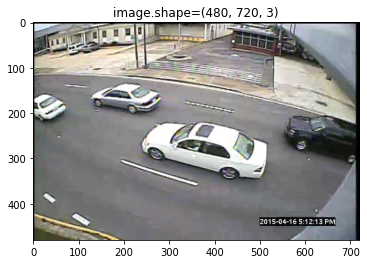

In [29]:
filename = "/mywork/PGDDS-IIITB/MyDatasets/MIO-TCD/MIO-TCD-Localization/test/00138455.jpg"
image=cv2.imread(filename)
img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
plt.imshow(img_rgb)
plt.title("image.shape={}".format(image.shape))
plt.show()

In [42]:
from PIL import Image
image = Image.open(filename)
image.size
#image

(720, 480)

In [30]:
input_w, input_h = 416, 416
#filename='cat-dog.jpg'
image, image_w, image_h = load_image_and_convert_scaled_pixels(filename,(input_w, input_h))



(1, 416, 416, 32)


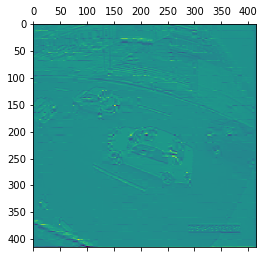

In [37]:
'''
Visualizing intermediate activations
before adding any loss/detection head, we can try to visualize the intermediate activations
'''
from keras import models
layer_indx=0
for layer in infer_model.layers:
    if(layer.name == 'conv_80'):
        break
    layer_indx+=1
    
#layer_outputs = [layer.output for layer in infer_model.layers[:layer_indx]]
layer_outputs = [layer.output for layer in infer_model.layers[:20]]
activation_model = models.Model(infer_model.input, layer_outputs)
#activation_model.summary()
activations = activation_model.predict(image)
first_layer_activation = activations[1]
print(first_layer_activation.shape)

# its a 416x416 feature map with 32 channels, trying to plot 4rth channel of the first layer of activation
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

/home/jmajumde/mypython3env/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.


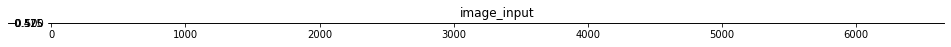

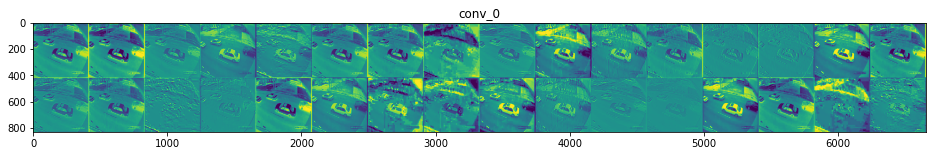

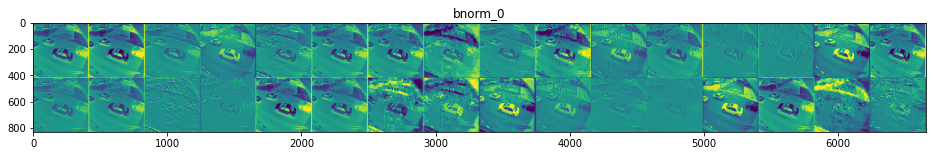

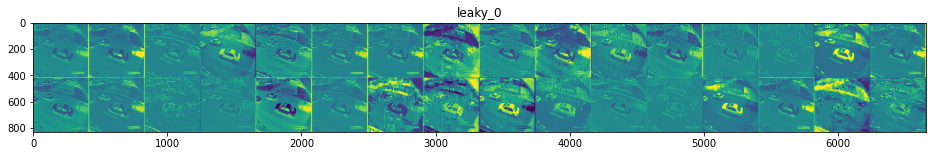

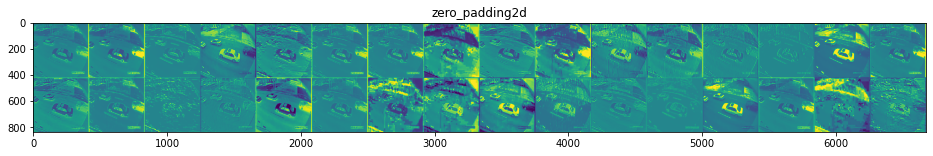

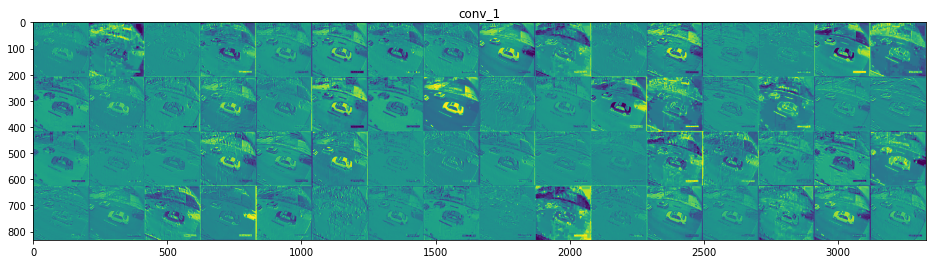

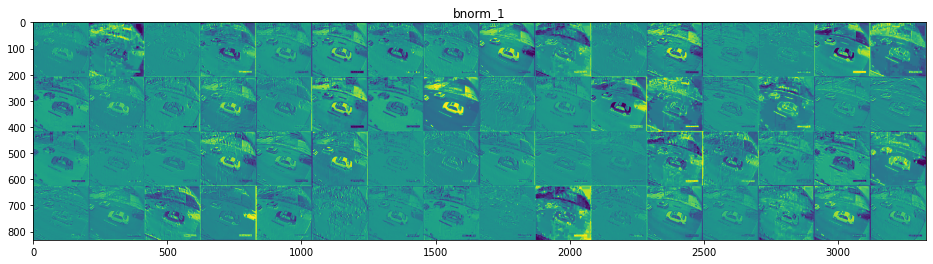

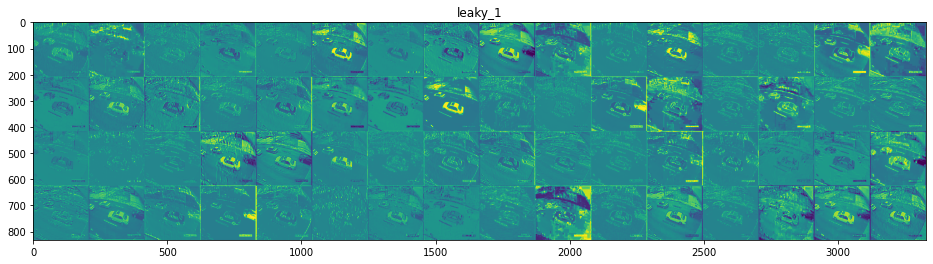

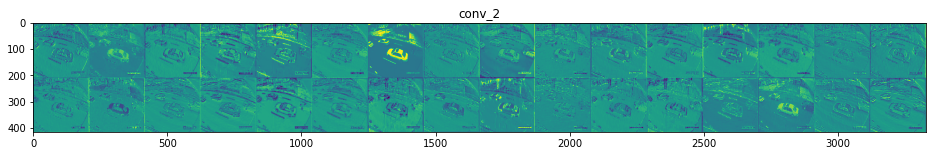

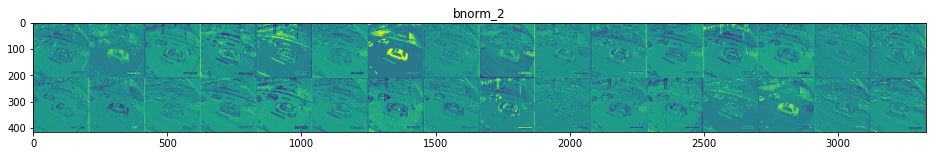

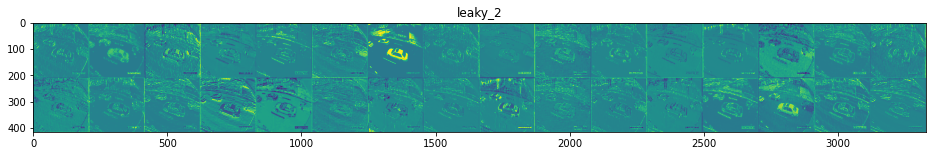

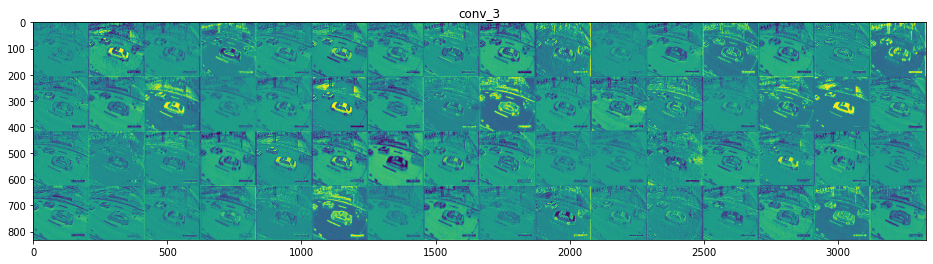

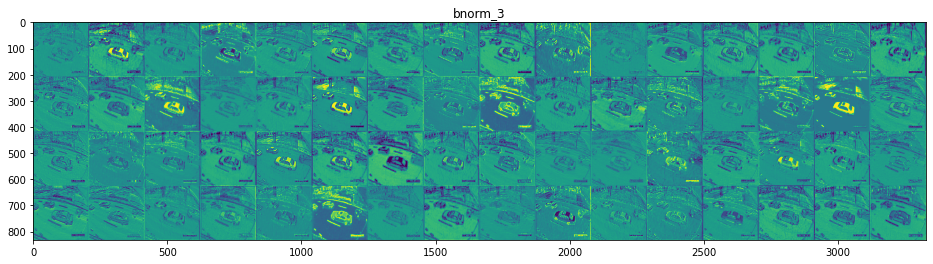

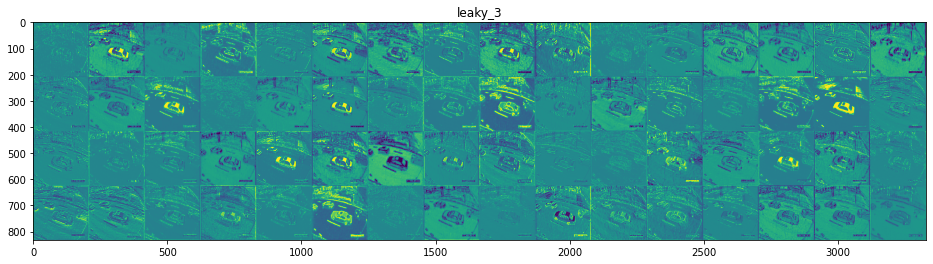

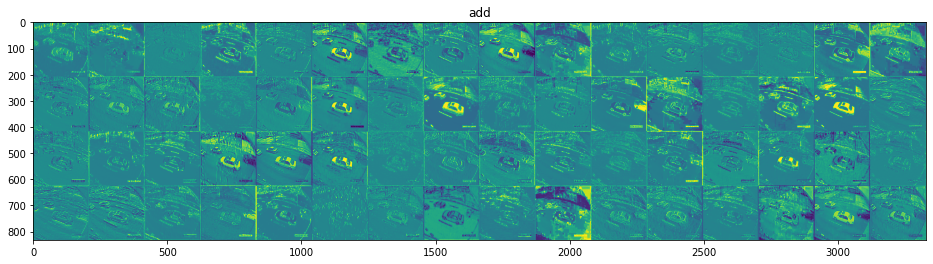

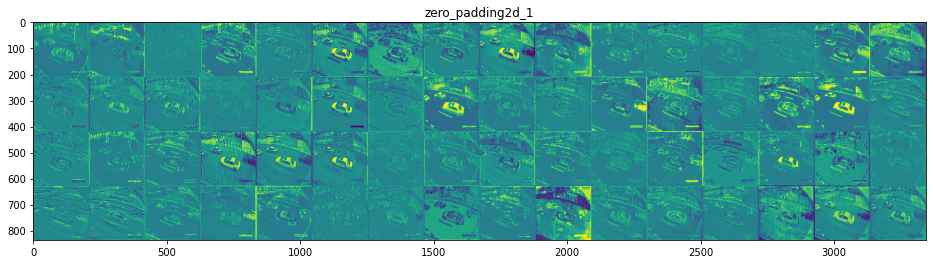

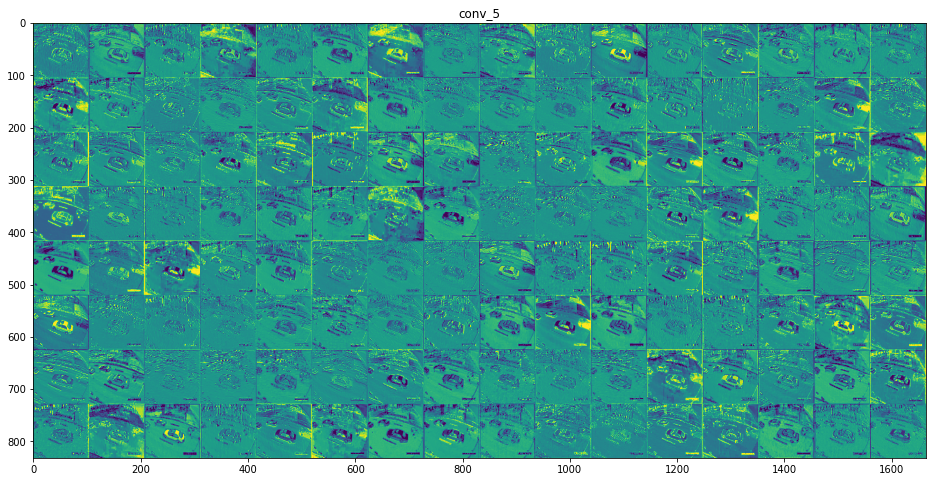

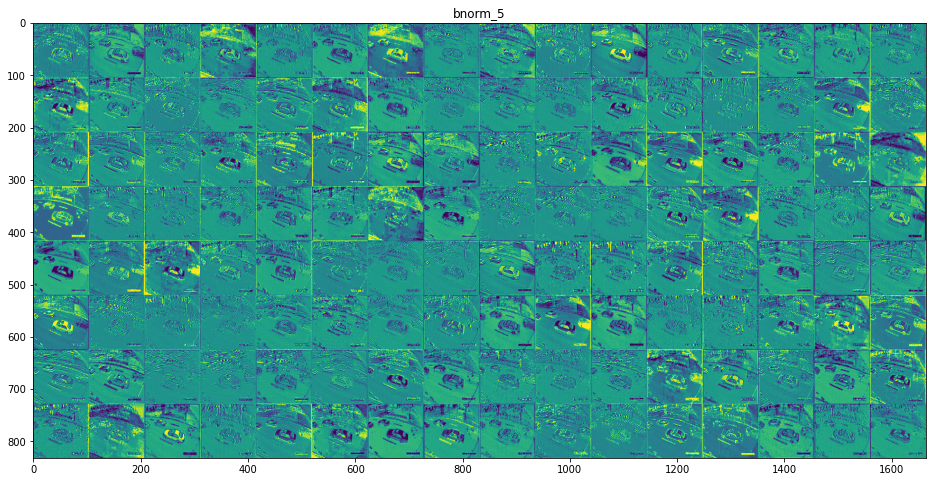

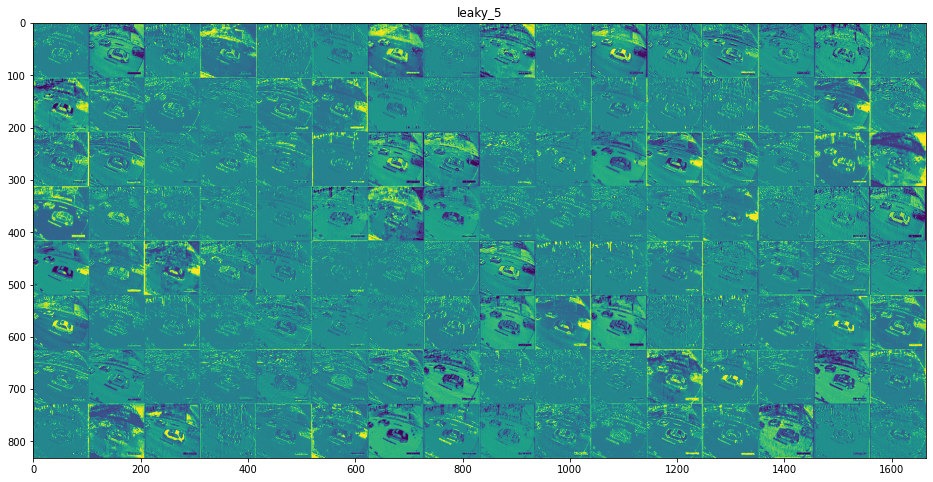

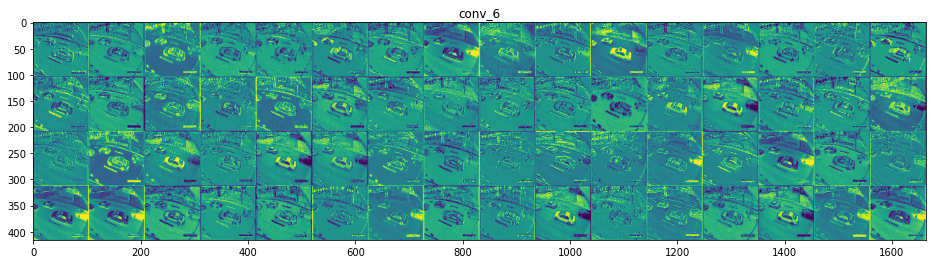

In [38]:
# code is mostly taken from "Deep Learning with Python" book by Chollet
# visualizing activations for 15 layers
layer_indx=20
layer_names = []
for layer in infer_model.layers[:layer_indx]:
    layer_names.append(layer.name)

images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    
    size = layer_activation.shape[1]
    
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [11]:
infer_model.output

[<tf.Tensor 'conv_81/BiasAdd:0' shape=(None, 13, 13, 48) dtype=float32>,
 <tf.Tensor 'conv_93/BiasAdd:0' shape=(None, 26, 26, 48) dtype=float32>,
 <tf.Tensor 'conv_105/BiasAdd:0' shape=(None, 52, 52, 48) dtype=float32>]

In [15]:
# make prediction
yolo_out = infer_model.predict(image)
print([a.shape for a in yolo_outputs])

[(1, 13, 13, 48), (1, 26, 26, 48), (1, 52, 52, 48)]


In [13]:
def decode_yolo_netout(netout, anchors, obj_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    #grid_h, grid_w, nb_box = netout.shape[:3]
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5

    boxes = []

    netout[..., :2] = sigmoid(netout[..., :2])
    netout[..., 4] = sigmoid(netout[..., 4])
    netout[..., 5:] = netout[..., 4][..., np.newaxis] * softmax(netout[..., 5:])
    #netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for i in range(grid_h * grid_w):
        row = i // grid_w
        col = i % grid_w

        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]

            if (objectness.all() <= obj_thresh): continue

            # last elements are class probabilities
            classes = netout[int(row)][int(col)][b][5:]
            #print(classes)

            #if np.sum(classes) > 0:
            #print(objectness, row, col, b)
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]
            #print(x, y, w, h)

            x = (col + x) / grid_w  # center position, unit: image width
            #print("x with grid scale: ",x)
            y = (row + y) / grid_h  # center position, unit: image height
            #print("y with grid scale: ",y)
            w = anchors[2 * b + 0] * np.exp(w) / net_w  # unit: image width
            #print("w width: ", w)
            h = anchors[2 * b + 1] * np.exp(h) / net_h  # unit: image height
            #print("h height: ", h)

            box = BoundingBox(x - w / 2, y - h / 2, x + w / 2, y + h / 2, objectness, classes)
            boxes.append(box)

    return boxes

def find_high_class_probability_bbox(netout_scale, object_thres):
    grid_h, grid_w = netout_scale.shape[:2]
    nb_box=3
    netout_scale = netout_scale.reshape((grid_h, grid_w, nb_box, -1))

    boxes = []
    for row in range(grid_h):
        for col in range(grid_w):
            for b in range(nb_box):
                # from 4th element onwards are confidence and class classes
                classes = netout_scale[row][col][b][5:]

                if np.sum(classes) > 0:
                    # first 4 elements are x, y, w, and h
                    x, y, w, h = netout_scale[row][col][b][:4]
                    confidence = netout_scale[row][col][b][4]
                    box = BoundingBox(x-w/2, y-h/2, x+w/2, y+h/2, confidence, classes)
                    if box.get_score() > object_thres:
                        boxes.append(box)
    return(boxes)


def print_decoded_yolo_netout_res(netout, ignore_thresh_for_tiny_box, ignore_thresh,
    boxes_with_tiny_thres, boxes ):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    thres_boxes=list()
    print("In total, YOLO produces GRID_H * GRID_W * BOX = {} bounding boxes for grid scale {}x{}".format( grid_h * grid_w * nb_box, grid_h, grid_w))
    for thres in (ignore_thresh_for_tiny_box, ignore_thresh):
        if thres == ignore_thresh_for_tiny_box:
            thres_boxes = boxes_with_tiny_thres
        else:
            thres_boxes = boxes
        print("****************")
        print("with obj_threshold={}".format(thres))
        print("found {} bounding boxes with top class probability > {}".format(len(thres_boxes),thres))



In [16]:
boxes = list()
netout = yolo_out
boxes += decode_yolo_netout(netout[0][0], anchors[12:], ignore_thresh, input_h, input_w)
boxes += decode_yolo_netout(netout[1][0], anchors[6:12], ignore_thresh, input_h, input_w)
boxes += decode_yolo_netout(netout[2][0], anchors[6:], ignore_thresh, input_h, input_w)

In [17]:
ignore_thresh=0.4
ignore_thresh_for_tiny_box=0.03
# decode network ooutput which is yhat in this case 13x13
feats=netout[0][0]
boxes13x = find_high_class_probability_bbox(feats, ignore_thresh)  # process 13x13 net out
boxes_with_tiny_thres13x = find_high_class_probability_bbox(feats, ignore_thresh_for_tiny_box)  
print_decoded_yolo_netout_res(feats, ignore_thresh_for_tiny_box, ignore_thresh,
    boxes_with_tiny_thres13x, boxes13x )

In total, YOLO produces GRID_H * GRID_W * BOX = 507 bounding boxes for grid scale 13x13
****************
with obj_threshold=0.03
found 1 bounding boxes with top class probability > 0.03
****************
with obj_threshold=0.4
found 0 bounding boxes with top class probability > 0.4


In [18]:
feats=netout[1][0]
boxes26x = find_high_class_probability_bbox(feats, ignore_thresh)  # process 26x26 net out
boxes_with_tiny_thres26x = find_high_class_probability_bbox(feats, ignore_thresh_for_tiny_box)  
print_decoded_yolo_netout_res(feats, ignore_thresh_for_tiny_box, ignore_thresh,
    boxes_with_tiny_thres26x, boxes26x )

In total, YOLO produces GRID_H * GRID_W * BOX = 2028 bounding boxes for grid scale 26x26
****************
with obj_threshold=0.03
found 9 bounding boxes with top class probability > 0.03
****************
with obj_threshold=0.4
found 3 bounding boxes with top class probability > 0.4


In [19]:
feats=netout[2][0]
boxes52x = find_high_class_probability_bbox(feats, ignore_thresh)   # process 52x52 net out
boxes_with_tiny_thres52x = find_high_class_probability_bbox(feats, ignore_thresh_for_tiny_box)  
print_decoded_yolo_netout_res(feats, ignore_thresh_for_tiny_box, ignore_thresh,
    boxes_with_tiny_thres52x, boxes52x )

In total, YOLO produces GRID_H * GRID_W * BOX = 8112 bounding boxes for grid scale 52x52
****************
with obj_threshold=0.03
found 0 bounding boxes with top class probability > 0.03
****************
with obj_threshold=0.4
found 0 bounding boxes with top class probability > 0.4


In [26]:
boxes_scales=list()
boxes_scales = boxes13x + boxes26x + boxes52x

In [27]:
for i in range(len(boxes_scales)):
    xmin, xmax, ymin, ymax = boxes_scales[i].xmin, boxes_scales[i].xmax, boxes_scales[i].ymin, boxes_scales[i].ymax
    print("xmin {}, xmax {}, ymin {}, ymax {}".format(xmin, xmax, ymin, ymax))

xmin -725040, xmax 861120, ymin -589800, ymax 1071240
xmin -1623600, xmax 1782000, ymin -1365960, ymax 1953240
xmin -254160, xmax 658080, ymin -1088760, ymax 1234680


In [22]:
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    if (float(net_w) / image_w) < (float(net_h) / image_h):
        new_w = net_w
        new_h = (image_h * net_w) / image_w
    else:
        new_h = net_w
        new_w = (image_w * net_h) / image_h

    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w) / 2. / net_w, float(new_w) / net_w
        y_offset, y_scale = (net_h - new_h) / 2. / net_h, float(new_h) / net_h

        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

    return boxes

In [25]:
boxes_scales = correct_yolo_boxes(boxes_scales, image_h, image_w, input_h, input_w)
for i in range(len(boxes_scales)):
    xmin, xmax, ymin, ymax = boxes_scales[i].xmin, boxes_scales[i].xmax, boxes_scales[i].ymin, boxes_scales[i].ymax
    print("xmin {}, xmax {}, ymin {}, ymax {}".format(xmin, xmax, ymin, ymax))

xmin -725040, xmax 861120, ymin -589800, ymax 1071240
xmin -1623600, xmax 1782000, ymin -1365960, ymax 1953240
xmin -254160, xmax 658080, ymin -1088760, ymax 1234680


In [ ]:
###############################
#   Run the evaluation
###############################
# compute mAP for all the classes
average_precisions = evaluate(infer_model, validation_batch_generation)

# print the score
for label, average_precision in average_precisions.items():
    print(labels[label] + ': {:.4f}'.format(average_precision))
    print('mAP: {:.4f}'.format(sum(average_precisions.values()) / len(average_precisions)))